In [1]:
import os
import sys
import warnings

import albumentations as A
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import scipy
import seaborn as sns
import torch
from albumentations.pytorch.transforms import ToTensorV2
# from packages.lpproj_LPP import LocalityPreservingProjection
from lpproj import LocalityPreservingProjection
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint
from pytorchcv.model_provider import get_model as ptcv_get_model
# from utils import *
from scipy import linalg
from sklearn.metrics import log_loss, roc_auc_score
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import datasets, models, transforms
from torchvision.datasets import MNIST

sys.path.append('../scripts')

warnings.filterwarnings('ignore')

#### variable

In [2]:
fold_number = 0
batch_size = 64

#### data load 

fold,-1,0,1,2
ratio,0.006912,0.017692,0.017747,0.017877


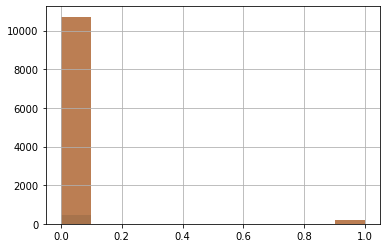

In [3]:
DATA_PATH = '../input/jpeg-melanoma-512x512/'
TRAIN_ROOT_PATH = f'{DATA_PATH}/train'
TEST_ROOT_PATH = f'{DATA_PATH}/test'

df_train = pd.read_csv(f'{DATA_PATH}/train.csv', index_col="image_name")
df_train["fold"] = df_train["tfrecord"] // 5
df_train = df_train.drop("tfrecord", axis=1)

df_test = pd.read_csv(f'{DATA_PATH}/test.csv', index_col="image_name")

_ = df_train.groupby('fold').target.hist(alpha=0.4)
df_train.groupby('fold').target.mean().to_frame('ratio').T


In [4]:
# DATA_PATH = '../input/melanoma-merged-external-data-512x512-jpeg'
# TRAIN_ROOT_PATH = f'{DATA_PATH}/512x512-dataset-melanoma/512x512-dataset-melanoma'
# TEST_ROOT_PATH = f'{DATA_PATH}/512x512-test/512x512-test'

# df_folds = pd.read_csv(f'{DATA_PATH}/folds.csv', index_col='image_id',
#                        usecols=['image_id', 'fold', 'target'], dtype={'fold': np.byte, 'target': np.byte})

# df_test = pd.read_csv(f'../input/siim-isic-melanoma-classification/test.csv', index_col='image_name')

# _ = df_folds.groupby('fold').target.hist(alpha=0.4)
# df_folds.groupby('fold').target.mean().to_frame('ratio').T


In [5]:
class ImageDataset(Dataset):
    def __init__(self, path, image_ids, labels=None, transforms=None):
        super().__init__()
        self.path = path
        self.image_ids = image_ids
        self.labels = labels
        self.transforms = transforms

    def __getitem__(self, idx: int):
        image_id = self.image_ids[idx]
        image = cv2.imread(f'{self.path}/{image_id}.jpg', cv2.IMREAD_COLOR)

        if self.transforms:
            sample = self.transforms(image=image)
            image  = sample['image']
            image = image.float()
            

        label = self.labels[idx] if self.labels is not None else 0.5
        return image, label

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def get_labels(self):
        return list(self.labels)

In [6]:
resolution = 456
input_res  = 512

def get_train_transforms():
    return A.Compose([
#             A.JpegCompression(p=0.5),
            A.Rotate(limit=80, p=1.0),
            A.OneOf([
                A.OpticalDistortion(),
                A.GridDistortion(),
                A.IAAPiecewiseAffine(),
            ]),
            A.RandomSizedCrop(min_max_height=(int(resolution*0.7), input_res),
                              height=resolution, width=resolution, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.GaussianBlur(p=0.3),
            A.OneOf([
                A.RandomBrightnessContrast(),   
                A.HueSaturationValue(),
            ]),
            A.Cutout(num_holes=8, max_h_size=resolution//8, max_w_size=resolution//8, fill_value=0, p=0.3),
            A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

def get_valid_transforms():
    return A.Compose([
            A.CenterCrop(height=resolution, width=resolution, p=1.0),
            A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

def get_tta_transforms():
    return A.Compose([
            A.JpegCompression(p=0.5),
            A.CenterCrop(height=resolution, width=resolution, p=1.0),
            A.RandomSizedCrop(min_max_height=(int(resolution*0.9), int(resolution*1.1)),
                              height=resolution, width=resolution, p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.5),
            A.Transpose(p=0.5),
            A.Normalize(),
            ToTensorV2(),
        ], p=1.0)

In [7]:
ds_train = ImageDataset(
    path=TRAIN_ROOT_PATH,
    image_ids=df_train[df_train['fold'] != fold_number].index.values,
    labels=df_train[df_train['fold'] != fold_number].target.values,
    transforms=get_train_transforms(),
)

ds_val = ImageDataset(
    path=TRAIN_ROOT_PATH,
    image_ids=df_train[df_train['fold'] == fold_number].index.values,
    labels=df_train[df_train['fold'] == fold_number].target.values,
    transforms=get_valid_transforms(),
)

ds_test = ImageDataset(
    path=TEST_ROOT_PATH,
    image_ids=df_test.index.values,
    transforms=get_tta_transforms(),
)

# del df_train
# len(ds_train), len(ds_val), len(ds_test)

In [ ]:
# class TableEmbedding(pl.LightningModule):

#     def __init__(self, ds_train, ds_val, batch_size=64, output_dim=None):
            
#         super(MultiOutputRegression, self).__init__()
        
#         self.ds_train = ds_train
#         self.ds_val = ds_val
#         self.batch_size = batch_size
        
#         input_dim = ds_train.data.shape[1]
#         self.input_dim = input_dim
#         if output_dim is None:
#             output_dim = input_dim
            
#         self.layer_1 = torch.nn.Linear(input_dim, 256)     
#         self.layer_2 = torch.nn.Linear(256, 256)
#         self.layer_3 = torch.nn.Linear(256, 128)
#         self.layer_4 = torch.nn.Linear(128, output_dim)

#     def forward(self, x):
#         x = x.view(-1, self.input_dim)
#         # layer 1
        
#         x = self.layer_1(x)
#         x = torch.relu(x)

#         # layer 2
#         x = self.layer_2(x)
#         x = torch.relu(x)
        
#         # layer 3
#         x = self.layer_3(x)
#         x = torch.relu(x)
        
#         # layer 4
#         x = self.layer_4(x)

#         return x

In [ ]:
# class ConcatModel(pl.LightningModule):

#     def __init__(self, ds_train, ds_val, batch_size=64, output_dim=None):
            
#         super(MultiOutputRegression, self).__init__()
        
#         self.ds_train = ds_train
#         self.ds_val = ds_val
#         self.batch_size = batch_size
        
#         input_dim = ds_train.data.shape[1]
#         self.input_dim = input_dim
#         if output_dim is None:
#             output_dim = input_dim
            
#         self.layer_1 = torch.nn.Linear(input_dim, 256)     
#         self.layer_2 = torch.nn.Linear(256, 256)
#         self.layer_3 = torch.nn.Linear(256, 128)
#         self.layer_4 = torch.nn.Linear(128, output_dim)
        
        
#         self.val_losses = list()

#     def forward(self, x):
#         x = x.view(-1, self.input_dim)
#         # layer 1
        
#         x = self.layer_1(x)
#         x = torch.relu(x)

#         # layer 2
#         x = self.layer_2(x)
#         x = torch.relu(x)
        
#         # layer 3
#         x = self.layer_3(x)
#         x = torch.relu(x)
        
#         # layer 4
#         x = self.layer_4(x)

#         return x
    
#     def loss_function(self, y_pred, y_true):
#         y_true = y_true.view(-1, self.input_dim)
#         return torch.nn.MSELoss()(y_pred, y_true)
    
#     def training_step(self, train_batch, batch_idx):
#         x, y_true = train_batch
#         y_pred = self.forward(x)
#         loss = self.loss_function(y_pred, y_true)

#         logs = {'train_loss': loss}
#         return {'loss': loss, 'log': logs}

#     def validation_step(self, val_batch, batch_idx):
#         x, y_true = val_batch
#         y_pred = self.forward(x)
#         loss = self.loss_function(y_pred, y_true)
# #         global cnt
# #         cnt += 1
# #         if cnt==3000:
# #             from IPython.core.debugger import Pdb; Pdb().set_trace()

#         return {'val_batch_loss': loss}

#     def validation_epoch_end(self, outputs):
#         # called at the end of the validation epoch
#         # outputs is an array with what you returned in validation_step for each batch
#         # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
#         avg_loss = torch.stack([x['val_batch_loss'] for x in outputs]).mean()
#         tensorboard_logs = {'val_loss': avg_loss}
#         self.val_losses.append(float(avg_loss.cpu().numpy()))
#         return {'val_loss': avg_loss, 'log': tensorboard_logs}
    
# #     def test_step(self, test_batch, batch_idx):
# #         x, y_true = test_batch
# #         y_pred = self.forward(x)
# #         loss = self.loss_function(y_pred, y_true)
# #         return {'test_batch_loss': loss}

# #     def test_epoch_end(self, outputs):
# #         # called at the end of the test epoch
# #         # outputs is an array with what you returned in test_step for each batch
# #         # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
# #         avg_loss = torch.stack([x['test_batch_loss'] for x in outputs]).mean()
# #         tensorboard_logs = {'test_loss': avg_loss}
# #         self.test_losses.append(float(avg_loss.cpu().numpy()))
# #         return {'test_loss': avg_loss, 'log': tensorboard_logs}
    
#     def prepare_data(self): 
#         pass
    
#     def train_dataloader(self): 
#         return DataLoader(self.ds_train, batch_size=self.batch_size)# num_workers=-1) 

#     def val_dataloader(self): 
#         return DataLoader(self.ds_val, batch_size=self.batch_size)# num_workers=-1) 

# #     def test_dataloader(self): 
# #         return DataLoader(self,dataset_test, batch_size=self.batch_size) 

#     def configure_optimizers(self): 
#         optimizer = torch.optim.Adam(self.parameters(), lr=1e-4) 
#         return optimizer 


In [8]:
class MelanomaModel(pl.LightningModule):

    def __init__(self, ds_train, ds_val, output_dim=None):
            
        super(MelanomaModel, self).__init__()
        
        self.ds_train = ds_train
        self.ds_val = ds_val
        self.ds_test = ds_test
        self.val_logloss = list()
        self.val_auc = list()

#         self.net = models.resnet18(pretrained=True)
#         self.net.fc = nn.Linear(in_features=self.net.fc.in_features, out_features=1)
        self.net = ptcv_get_model("efficientnet_b2c", pretrained=True)
        self.net.output.fc = nn.Linear(in_features=self.net.output.fc.in_features, out_features=1)
        
        
    def forward(self, x):
        x = self.net(x)
        return x
    
    def loss_function(self, y_pred, y_true):
        loss = nn.BCEWithLogitsLoss()
        return loss(y_pred, y_true)
    
    def training_step(self, train_batch, batch_idx):
        x, y_true = train_batch
        y_pred = self.forward(x).flatten()
        loss = self.loss_function(y_pred, y_true.type_as(y_pred))

        logs = {'train_loss': loss}
        return {'loss': loss, 'log': logs}

    def validation_step(self, val_batch, batch_idx):
        x, y_true = val_batch
        logits = self(x)
        y_pred = logits.flatten()
        probs = torch.sigmoid(logits)
#         loss = self.loss_function(y_pred, y_true.type_as(y_pred))
#         return {'val_batch_loss': loss, 'probs':probs, 'y_true':y_true}
        return {'probs':probs, 'y_true':y_true}

    def validation_epoch_end(self, outputs):
        # called at the end of the validation epoch
        # outputs is an array with what you returned in validation_step for each batch
        # outputs = [{'loss': batch_0_loss}, {'loss': batch_1_loss}, ..., {'loss': batch_n_loss}] 
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        
        y_true = torch.cat([out['y_true'] for out in outputs], dim=0)
        y_true = y_true.detach().cpu().numpy()
        
        self.val_predicts = probs  # Save prediction internally for easy access
        auc_score = roc_auc_score(y_true, probs)
        cross_entropy = log_loss(y_true, probs)
        
        tensorboard_logs = {'valid_logloss': cross_entropy, 'valid_auc':auc_score}
        self.val_logloss.append(cross_entropy)
        self.val_auc.append(auc_score)
        return {'val_loss': cross_entropy, 'log': tensorboard_logs}
    
    def test_step(self, batch, batch_idx):
        x, _ = batch

        logits = self(x)
        probs = torch.sigmoid(logits)
        
        return {'probs': probs}
    
    def test_epoch_end(self, outputs):
        probs = torch.cat([out['probs'] for out in outputs], dim=0)
        probs = probs.detach().cpu().numpy()
        self.test_predicts = probs  # Save prediction internally for easy access
        # We need to return something 
        return {'dummy_item': 0}
    
    
    def prepare_data(self): 
        pass
    
    def train_dataloader(self): 
        return DataLoader(self.ds_train, batch_size=batch_size, num_workers=8, shuffle=True) 

    def val_dataloader(self): 
        return DataLoader(self.ds_val, batch_size=batch_size, num_workers=8) 

    def test_dataloader(self): 
        return DataLoader(self.ds_test, batch_size=batch_size, num_workers=8) 

    def configure_optimizers(self): 
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-5) 
        return optimizer 


In [ ]:
checkpoint_callback = ModelCheckpoint(
    filepath="./lightning_logs/",
    save_top_k=4,
    verbose=False,
    monitor='val_loss',
    mode='min',
)

early_stop_callback = EarlyStopping(
   monitor='val_loss',
   min_delta=0.00,
   patience=20,
   verbose=True,
   mode='min'
)


# train
model = MelanomaModel(ds_train, ds_val) 

trainer = pl.Trainer(max_epochs=100000, checkpoint_callback=checkpoint_callback,
                     early_stop_callback=early_stop_callback, gpus=[4,5])

trainer.fit(model)


INFO:lightning:GPU available: True, used: True
INFO:lightning:CUDA_VISIBLE_DEVICES: [4,5]
INFO:lightning:
    | Name                                    | Type              | Params
--------------------------------------------------------------------------
0   | net                                     | EfficientNet      | 7 M   
1   | net.features                            | Sequential        | 7 M   
2   | net.features.init_block                 | EffiInitBlock     | 928   
3   | net.features.init_block.conv            | ConvBlock         | 928   
4   | net.features.init_block.conv.conv       | Conv2d            | 864   
5   | net.features.init_block.conv.bn         | BatchNorm2d       | 64    
6   | net.features.init_block.conv.activ      | Swish             | 0     
7   | net.features.stage1                     | Sequential        | 2 K   
8   | net.features.stage1.unit1               | EffiDwsConvUnit   | 1 K   
9   | net.features.stage1.unit1.dw_conv       | ConvBlock         | 3

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



#### inference

In [11]:
trainer.test(model)

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.

INFO:root:
Unfortunately, your original traceback can not be constructed.



Traceback (most recent call last):
  File "/home/sano/env36/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 3331, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-11-a549be9bb6fe>", line 1, in <module>
    trainer.test(model)
  File "/home/sano/env36/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py", line 958, in test
    self.fit(model)
  File "/home/sano/env36/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py", line 759, in fit
    self.dp_train(model)
  File "/home/sano/env36/lib/python3.6/site-packages/pytorch_lightning/trainer/distrib_parts.py", line 563, in dp_train
    self.run_pretrain_routine(model)
  File "/home/sano/env36/lib/python3.6/site-packages/pytorch_lightning/trainer/trainer.py", line 874, in run_pretrain_routine
    self.restore_weights(model)
  File "/home/sano/env36/lib/python3.6/site-packages/pytorch_lightning/trainer/training_io.py", line 155, in restore_weights
    torch.

KeyboardInterrupt: 

In [ ]:
submission = pd.read_csv(f"{DATA_PATH}sample_submission.csv")
submission["target"] = model.test_predicts.squeeze()

#### save

In [ ]:
SAVE_PATH = "../output/"
submission.to_csv(f"{SAVE_PATH}submission.csv", index=False)

In [ ]:
model.current_epoch

In [ ]:
 
#画像と対応する行がin

    # tableの推論
    x1 = mlp１(series)
    
    # 画像の推論
    model.eval()
    with torch.no_grad():
        x2 = model.get_feature(image) 
    
    #　くっつける
    x_cat = torch.cat([x1,x2])
    
    #　予測
    logits = mlp2(x_cat)
    